In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import matplotlib.colors as colors

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view 

import tqdm
import collections
try:
    import cPickle as pickle
except:
    import pickle

import setigen as stg
import blscint as bls
from blscint.observations.organization import DSFile, DSPointing, DSCadence
from blscint.remote import dsc_cadence 

import scipy.special
import scipy.stats
from astropy.stats import sigma_clip

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import pandas as pd
import sqlite3

import jort
import os
import copy
import shutil
import psutil
from pathlib import Path
import contextlib
import subprocess

import sys 
sys.path.insert(0, '../brkl-111_dedoppler_pipeline')
import survey_direction_filter as sdf

DATA_DIR = Path("/datax2/users/bryanb")
DB_PATH = DATA_DIR / "pipeline.sqlite3"
DIAGSTAT_DIR = DATA_DIR / "scintillation_diagstats"
FIGURES_DIR = Path("/home/bryanb/scintillation_project/scintillation_search_paper/scintillation-search-paper/figures/")

model_frame = stg.Frame.from_backend_params(fchans=256, 
                                            obs_length=600,
                                            int_factor=7)
model_frame.get_params()

{'fchans': 256,
 'tchans': 239,
 'df': 2.7939677238464355,
 'dt': 2.505397589333333,
 'fch1': 6000000000.0,
 'ascending': False}

In [2]:
%matplotlib inline

In [4]:
!ls /datax2/users/bryanb/scintillation_diagstats/*synthetic*

/datax2/users/bryanb/scintillation_diagstats/synthetic-t_d10-snr10-injected.diagstat.csv
/datax2/users/bryanb/scintillation_diagstats/synthetic-t_d10-snr25-injected.diagstat.csv
/datax2/users/bryanb/scintillation_diagstats/synthetic-t_d100-snr10-injected.diagstat.csv
/datax2/users/bryanb/scintillation_diagstats/synthetic-t_d100-snr25-injected.diagstat.csv
/datax2/users/bryanb/scintillation_diagstats/synthetic-t_d30-snr10-injected.diagstat.csv
/datax2/users/bryanb/scintillation_diagstats/synthetic-t_d30-snr25-injected.diagstat.csv


In [5]:
generator = bls.SignalGenerator(**model_frame.get_params(), seed=0)
t_ds = [10, 30, 100]
for t_d in t_ds:
    generator.make_dataset(t_d, 
                           n=1000, 
                           snr=33,
                           bw=8,
                           injected=True, 
                           file_stem=f"synthetic-t_d{t_d}-snr33") 

100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.30it/s]


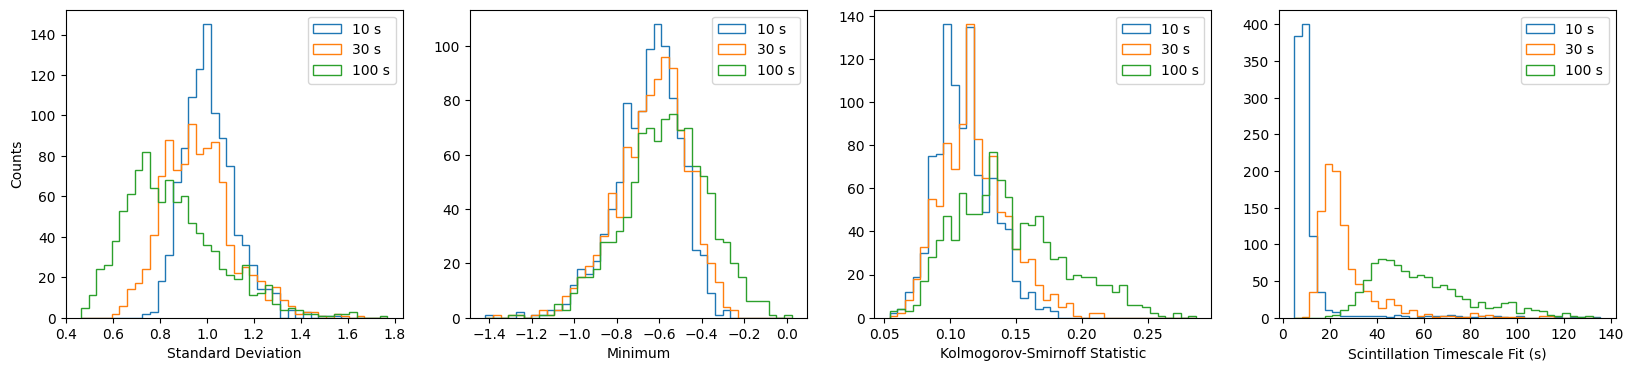

In [7]:
manager = bls.SignalManager() 
for t_d in t_ds:
    manager.add_synthetic(f"synthetic-t_d{t_d}-snr33.diagstat.csv",
                          label=f"t_d{t_d}") 

filters = [] 
for t_d in t_ds:
    filters.append({
        "label": f"{t_d} s", 
        "df": manager.df[manager.df["label"] == f"t_d{t_d}"]
    })
    
manager.plot_histograms(filters=filters)

plt.savefig(FIGURES_DIR / 'synthetic_scintillation_snr33.pdf', bbox_inches='tight')
plt.show()

First, load in all cadence info:

In [3]:
tr = jort.Tracker()
tr.start('load cadences')
with open('full_processed_cadences.pickle', 'rb') as f:
    cadence_list = pickle.load(f)
tr.stop()
tr.report()

len(cadence_list)

load cadences.stop INFO     Elapsed time: 279.9 s

Session: None
load cadences | 279.9 s ± 0.0 s per iteration, n = 1



37

Then load in NGP pointing information:

In [4]:
_, NGP_pointings = sdf.construct_cadence_list(sdf.nested_target_list)
len(NGP_pointings)

Completed session 0 (1 of 5)
Completed session 1 (2 of 5)
Completed session 2 (3 of 5)
Completed session 3 (4 of 5)
Completed session 4 (5 of 5)


5

Collecting all hits from target cadences:

In [5]:
hits_dfs = []
events_dfs = []
partial_events_dfs = []
for c in cadence_list:
    events_dfs.append(c.events)
    partial_events_dfs.append(c.partial_events)
    for p in c:
        # hits_df = p.hits[p.hits['node']=='blc61']
        hits_df = p.hits
        hits_dfs.append(hits_df)
df_hits = pd.concat(hits_dfs)
df_events = pd.concat(events_dfs)
df_partial_events = pd.concat(partial_events_dfs)
print(df_hits.shape)
print(df_events.shape)
print(df_partial_events.shape)
df_hits.head()

(1277325, 610)
(12036, 613)
(106096, 613)


,TopHitNum,DriftRate,SNR,Uncorrected_Frequency,Corrected_Frequency,ChanIndx,FreqStart,FreqEnd,SEFD,SEFD_freq,...,num_hits_rfi_DIAG_SCINT_GC_C10_0028,idx_hits_rfi_DIAG_SCINT_GC_C10_0028,num_hits_DIAG_SCINT_GC_C12_0029,idx_hits_DIAG_SCINT_GC_C12_0029,num_hits_rfi_DIAG_SCINT_GC_C12_0029,idx_hits_rfi_DIAG_SCINT_GC_C12_0029,num_hits_DIAG_SCINT_GC_C10_0026,idx_hits_DIAG_SCINT_GC_C10_0026,num_hits_rfi_DIAG_SCINT_GC_C10_0026,idx_hits_rfi_DIAG_SCINT_GC_C10_0026
0,1,0.126824,10.069126,8438.699626,8438.699626,94925,8438.712406,8438.686850,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.004373,142.755524,8438.500000,8438.500000,166374,8438.512780,8438.487223,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.100585,395.154938,8438.399719,8438.399719,202266,8438.412499,8438.386942,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.056852,3406.843262,8438.099815,8438.099815,309606,8438.112594,8438.087038,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.104958,311.695190,8437.987648,8437.987648,349752,8438.000428,8437.974871,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
